# Mask R-CNN - Inspect Pantograph Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Add root to path 
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

# Import pantogrograph class
from dev import pantograph

/Users/jessedecker/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jessedecker/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jessedecker/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jessedecker/miniconda3/envs/tf

## Configurations

Configurations are defined in balloon.py

In [2]:
config = pantograph.PantographConfig()
config.display()


Configurations Superlee:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_MASK_POOL_SIZE        7
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               128
MEAN_PIXEL                

## Dataset

In [3]:
# Set path to root of images. 
DATA_DIR = os.path.join(ROOT_DIR, "datasets/pantograph")

# Load dataset
dataset = pantograph.PantographDataset()
dataset.load_pantograph(DATA_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))

for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Skeleton: (5, 2)
Keypoint names: (6,)
Image Count: 8
Class Count: 4
  0. BG                                                
  1. front_bar                                         
  2. middle_bar                                        
  3. rear_bar                                          


In [ ]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)

## Display Samples

Load and display images and masks.

In [ ]:
'''
Display Image
'''

# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)

display_images([image],cols=1)

In [ ]:
'''
Display Top Mask
'''

# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)

mask, class_ids = dataset.load_mask(image_id)

visualize.display_top_masks(image, mask, class_ids, dataset.class_names,limit=3)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)

# Load from mask OR keypoint
# mask, class_ids = dataset.load_mask(image_id)
keypoints, masks, class_ids = dataset.load_keypoints(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(masks)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))

# Display bbox
# visualize.display_instances(image, bbox, masks, class_ids, dataset.class_names)

visualize.draw_boxes(image, boxes=bbox,masks=masks)

#
# visualize.display_keypoints(image,bbox,keypoints,class_ids,dataset.class_names)


In [ ]:
image_id = random.choice(dataset.image_ids)

image, image_meta, class_ids, bbox, mask, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config,image_id, augment=False,use_mini_mask=config.USE_MINI_MASK)

# visualize.display_keypoints(original_image,gt_bbox,gt_keypoint,gt_class_id,dataset.class_names)
visualize.display_keypoints(image,bbox,keypoints,class_ids,dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)

mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape

# Resize
image, window, scale, padding = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
print("New shape: ", image.shape)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

In [ ]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=False, use_mini_mask=False)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)


display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [4]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  65472
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192


padding [(224, 224), (0, 0), (0, 0)]
Level 0. Anchors:  49152  Feature map Shape: [256 256]
Level 1. Anchors:  12288  Feature map Shape: [128 128]
Level 2. Anchors:   3072  Feature map Shape: [64 64]
Level 3. Anchors:    768  Feature map Shape: [32 32]
Level 4. Anchors:    192  Feature map Shape: [16 16]


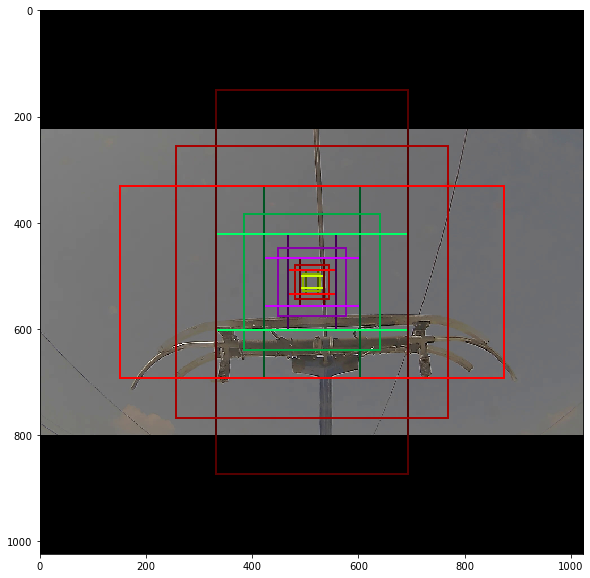

In [5]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead

padding [(224, 224), (0, 0), (0, 0)]
padding [(224, 224), (0, 0), (0, 0)]

rois                     shape: (2, 100, 4)           min:    0.00000  max:    0.00000
target_class_ids         shape: (2, 100)              min:    0.00000  max:    0.00000
target_bbox              shape: (2, 100, 4)           min:    0.00000  max:    0.00000
target_keypoint_lables   shape: (2, 100, 6)           min:    0.00000  max:    0.00000
target_keypoint_weights  shape: (2, 100, 6)           min:    0.00000  max:    0.00000
target_mask              shape: (2, 100, 28, 28)      min:    0.00000  max:    0.00000
keypoint_shape: (0, 6, 3)

*** No persons to display *** 



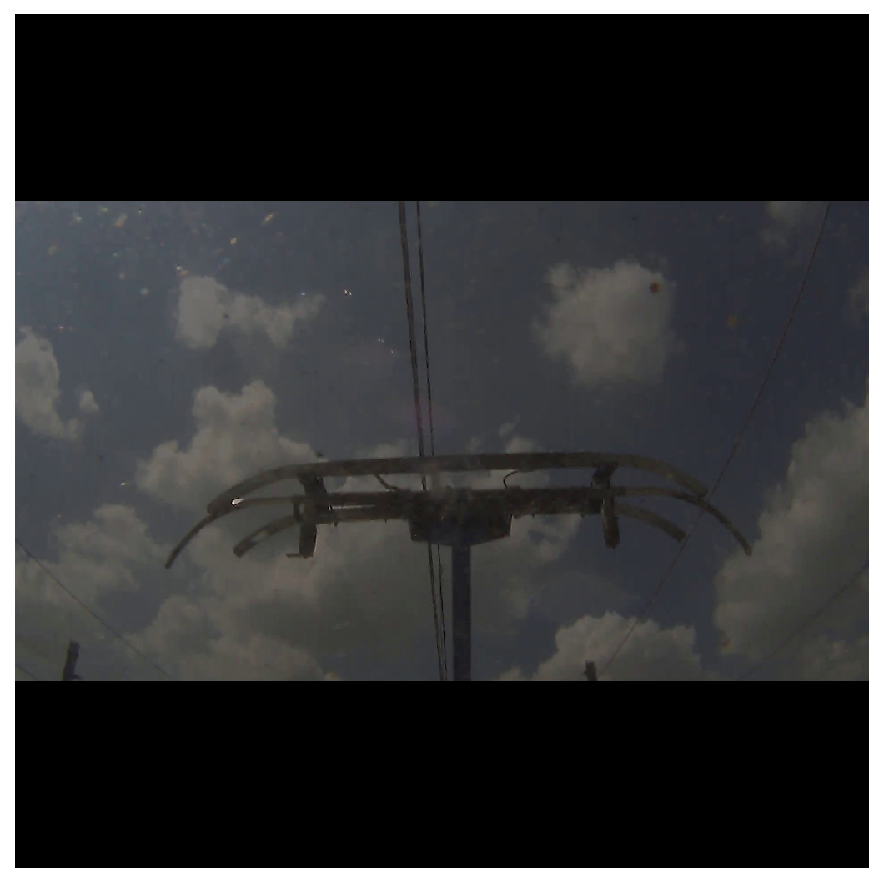

keypoint_shape: (0, 6, 3)

*** No persons to display *** 



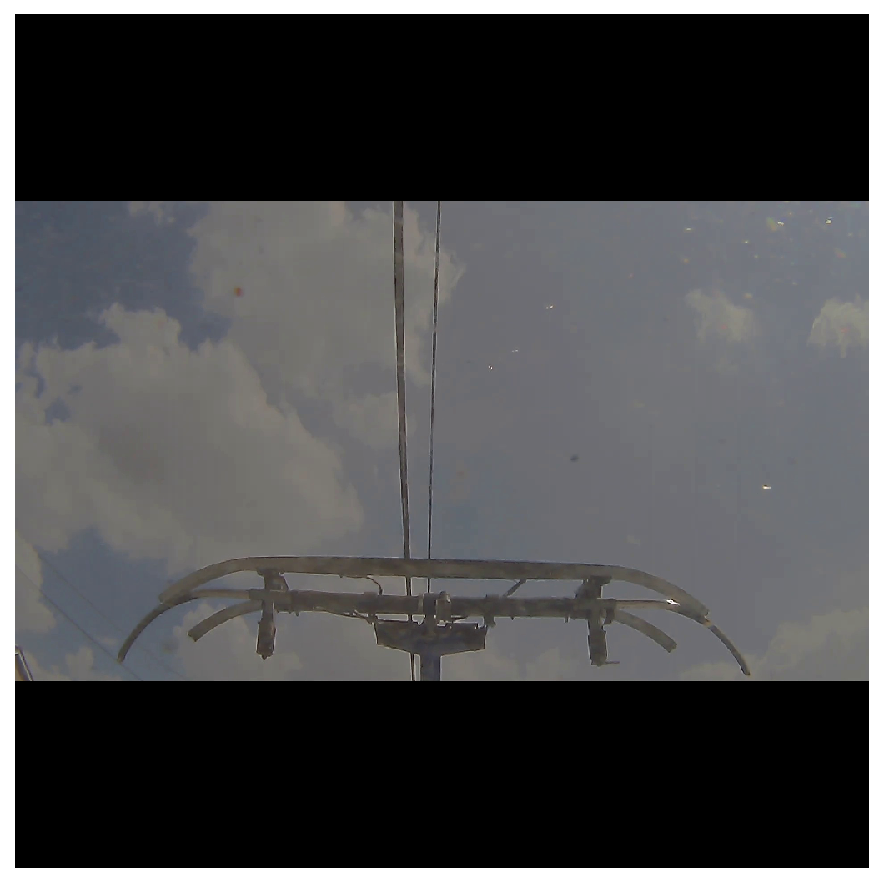

In [6]:


# # Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "mask_rcnn_coco_humanpose.h5")

# # Recreate the model in inference mode
model = modellib.MaskRCNN(mode="training", 
                          config=config,
                          model_dir=MODEL_DIR)


# rois, target_class_ids, target_bbox, target_keypoint, target_keypoint_weight, target_mask
train_keypoint_generator = modellib.data_generator_keypoint(dataset, config, shuffle=True,
                                         batch_size=config.BATCH_SIZE)

#python 3.* use next(generator)
inputs,_ = next(train_keypoint_generator)

batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox, batch_gt_class_ids, \
            batch_gt_boxes, batch_gt_keypoints,batch_gt_masks  = inputs


rpn = model.run_graph(inputs, [
    ("rois", model.keras_model.get_layer("proposal_targets").output[0]),
    ("target_class_ids", model.keras_model.get_layer("proposal_targets").output[1]),
    ("target_bbox", model.keras_model.get_layer("proposal_targets").output[2]),
    ("target_keypoint_lables", model.keras_model.get_layer("proposal_targets").output[3]),
    ("target_keypoint_weights", model.keras_model.get_layer("proposal_targets").output[4]),
    ("target_mask", model.keras_model.get_layer("proposal_targets").output[5]),
])

roi = rpn["rois"]
target_class_ids = rpn["target_class_ids"]
target_bbox = rpn["target_bbox"]
target_keypoint_label = rpn["target_keypoint_lables"]
target_keypoint_weight = rpn["target_keypoint_weights"]
target_mask = rpn["target_mask"]
# gt_keypoints = rpn["gt_keypoints"]
keypoint_scales = [config.IMAGE_SHAPE[1],config.IMAGE_SHAPE[0],1]
# gt_keypoints = keypoint_scales*gt_keypoints

for i in range(config.BATCH_SIZE):
    batch_orignal_image = modellib.unmold_image(batch_images[i],config)
    visualize.display_image_keypoint_mask(batch_orignal_image,roi[i],target_keypoint_label[i],target_keypoint_weight[i],
                                          target_class_ids[i],dataset.class_names,config=config,iskeypointlabel= True)



## Data Generator


In [7]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [ ]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [8]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
# image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
# print("image_id: ", image_id, dataset.image_reference(image_id))

# # Remove the last dim in mrcnn_class_ids. It's only added
# # to satisfy Keras restriction on target shape.
# mrcnn_class_ids = mrcnn_class_ids[:,:,0]

ERROR:root:Error processing image {'id': 3, 'source': 'pantograph', 'path': '/Users/jessedecker/projects/rail_segmentation/datasets/pantograph/val/padd_to_swin_frame_215562.jpg', 'width': 1920, 'height': 1080, 'annotations': [{'area': 5463.6864, 'bbox': [444, 571, 1143, 163], 'category_id': 1, 'color': [255, 0, 0], 'id': 9, 'image_id': 3, 'iscrowd': 0, 'keypoints': [449, 719, 2, 620, 629, 2, 659, 621, 2, 1370, 594, 2, 1419, 598, 2, 1576, 676, 2], 'num_keypoints': 6.0, 'segmentation': [[448, 718, 449, 700, 450, 700, 451, 699, 452, 698, 453, 697, 454, 697, 455, 696, 456, 695, 457, 695, 458, 694, 459, 693, 460, 692, 461, 692, 462, 691, 463, 690, 464, 690, 465, 689, 466, 688, 467, 687, 468, 687, 469, 686, 470, 685, 471, 685, 472, 684, 473, 683, 474, 682, 475, 682, 476, 681, 477, 680, 478, 680, 479, 679, 480, 678, 481, 678, 482, 677, 483, 676, 484, 676, 485, 675, 486, 674, 487, 674, 488, 673, 489, 672, 490, 672, 491, 671, 492, 670, 493, 670, 494, 669, 495, 668, 496, 668, 497, 667, 498, 666,

padding [(224, 224), (0, 0), (0, 0)]
padding [(224, 224), (0, 0), (0, 0)]


ERROR:root:Error processing image {'id': 2, 'source': 'pantograph', 'path': '/Users/jessedecker/projects/rail_segmentation/datasets/pantograph/val/padd_to_swin_frame_37354.jpg', 'width': 1920, 'height': 1080, 'annotations': [{'area': 5463.6864, 'bbox': [378, 816, 1258, 147], 'category_id': 1, 'color': [255, 0, 0], 'id': 6, 'image_id': 2, 'iscrowd': 0, 'keypoints': [396, 950, 2, 583, 854, 2, 606, 850, 2, 1405, 837, 2, 1447, 843, 2, 1621, 930, 2], 'num_keypoints': 6.0, 'segmentation': [[382, 935, 383, 934, 384, 933, 385, 932, 386, 931, 387, 930, 388, 930, 389, 929, 390, 928, 391, 927, 392, 926, 393, 925, 394, 924, 395, 923, 396, 922, 397, 921, 398, 921, 399, 920, 400, 919, 401, 918, 402, 917, 403, 916, 404, 916, 405, 915, 406, 914, 407, 913, 408, 912, 409, 912, 410, 911, 411, 910, 412, 909, 413, 909, 414, 908, 415, 907, 416, 906, 417, 906, 418, 905, 419, 904, 420, 903, 421, 903, 422, 902, 423, 901, 424, 900, 425, 900, 426, 899, 427, 898, 428, 898, 429, 897, 430, 896, 431, 896, 432, 895, 

padding [(224, 224), (0, 0), (0, 0)]
padding [(224, 224), (0, 0), (0, 0)]


ERROR:root:Error processing image {'id': 0, 'source': 'pantograph', 'path': '/Users/jessedecker/projects/rail_segmentation/datasets/pantograph/val/swin_to_padd_frame_220500.jpg', 'width': 1920, 'height': 1080, 'annotations': [{'area': 5463.6864, 'bbox': [391, 676, 1199, 135], 'category_id': 1, 'color': [255, 0, 0], 'id': 0, 'image_id': 0, 'iscrowd': 0, 'keypoints': [406, 797, 2, 576, 710, 2, 610, 704, 2, 1374, 704, 2, 1409, 710, 2, 1576, 798, 2], 'num_keypoints': 6.0, 'segmentation': [[397, 787, 398, 784, 399, 782, 400, 779, 401, 778, 402, 777, 403, 776, 404, 776, 405, 775, 406, 774, 407, 773, 408, 772, 409, 771, 410, 770, 411, 769, 412, 769, 413, 768, 414, 767, 415, 766, 416, 765, 417, 765, 418, 764, 419, 763, 420, 762, 421, 762, 422, 761, 423, 760, 424, 759, 425, 759, 426, 758, 427, 757, 428, 757, 429, 756, 430, 755, 431, 755, 432, 754, 433, 753, 434, 753, 435, 752, 436, 751, 437, 751, 438, 750, 439, 750, 440, 749, 441, 748, 442, 748, 443, 747, 444, 747, 445, 746, 446, 746, 447, 745,

padding [(224, 224), (0, 0), (0, 0)]
padding [(224, 224), (0, 0), (0, 0)]


AttributeError: module 'scipy.misc' has no attribute 'imresize'

In [ ]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)


# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

In [ ]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

In [ ]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [ ]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))